In [37]:
#importing the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Get the dataset
df = pd.read_csv(r'./output/processed_data.csv')

# Data Visualisation

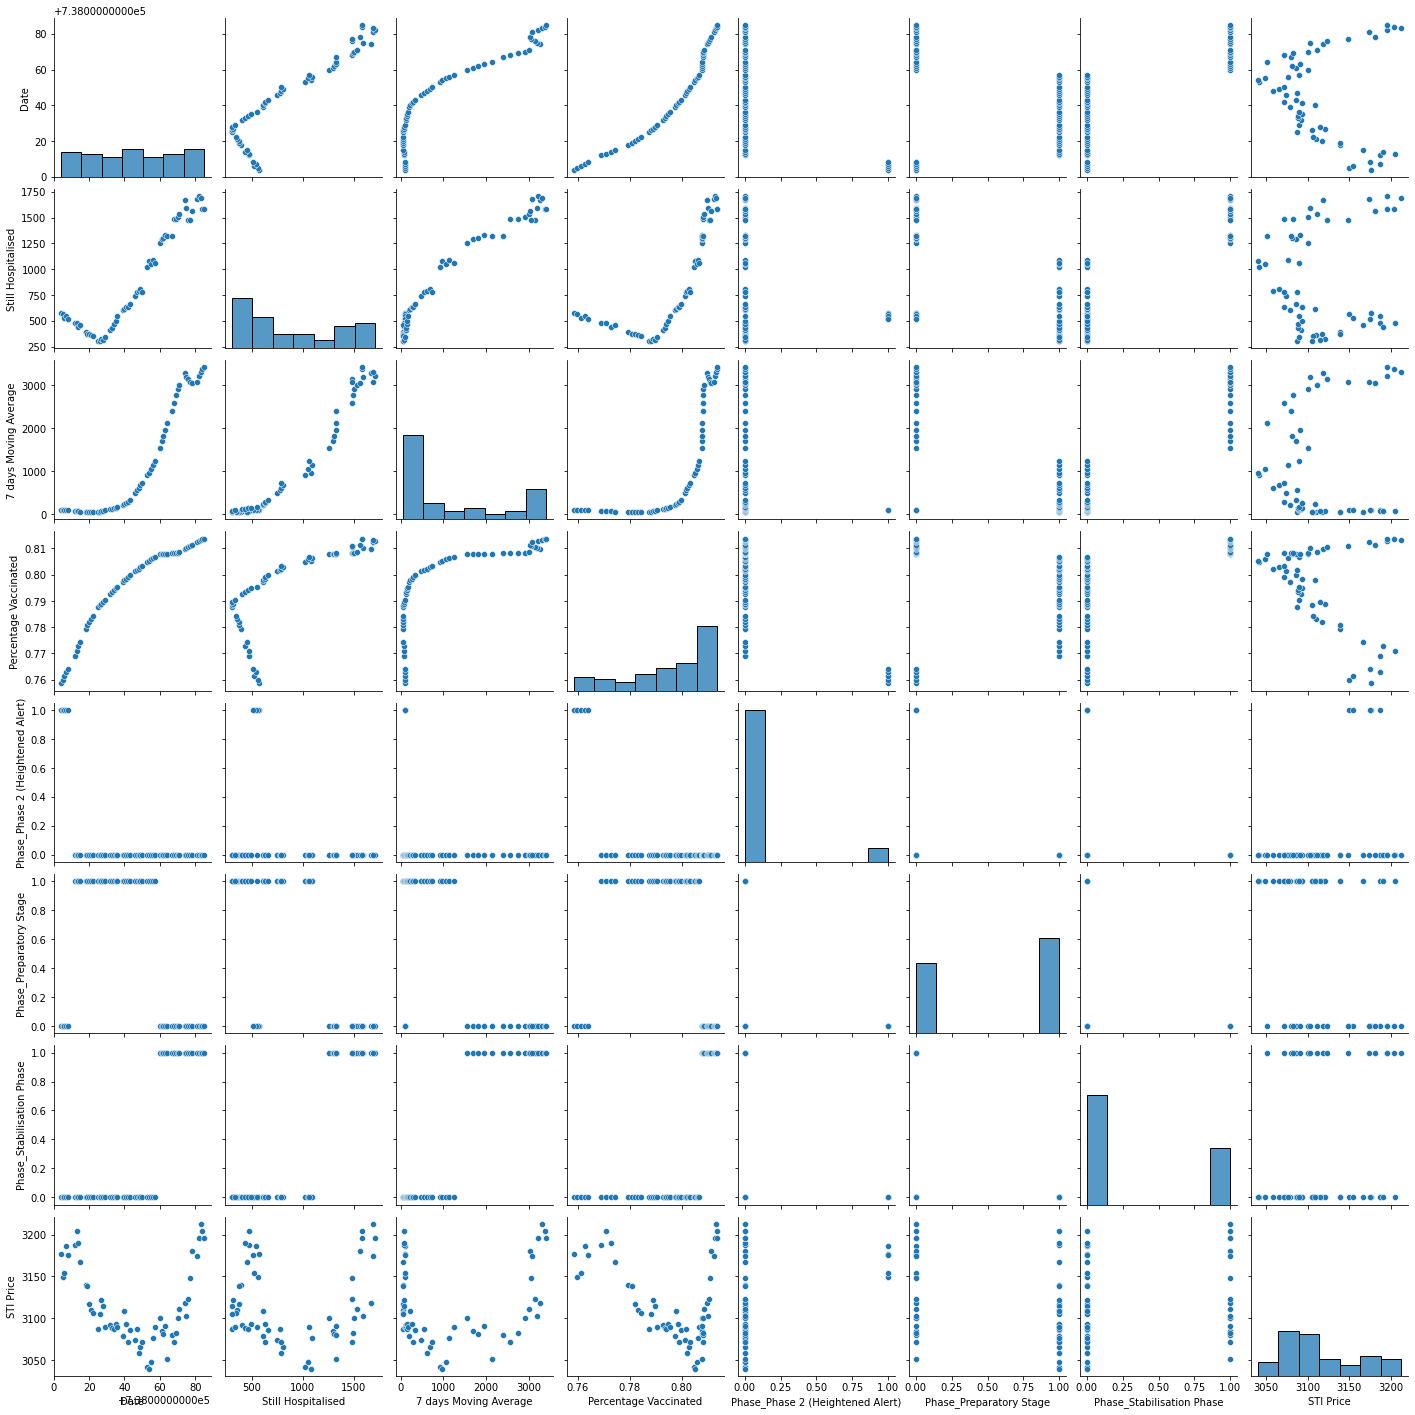

In [38]:
pp = sns.pairplot(data=df)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
# Further viz with q-q plot to visualize the distribution of the data

### Plotting Scatter Plots

In [39]:
df.columns

Index(['Date', 'Still Hospitalised', '7 days Moving Average',
       'Percentage Vaccinated', 'Phase_Phase 2 (Heightened Alert)',
       'Phase_Preparatory Stage', 'Phase_Stabilisation Phase', 'STI Price'],
      dtype='object')

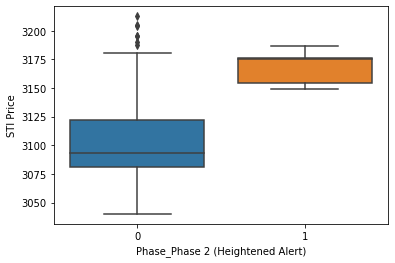

In [40]:
myplot = sns.boxplot(x='Phase_Phase 2 (Heightened Alert)', y='STI Price', data=df)

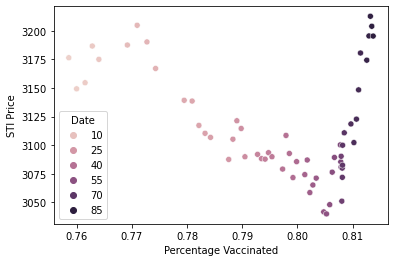

In [41]:
myplot = sns.scatterplot(hue = 'Date',x='Percentage Vaccinated', y='STI Price', data=df)

visualising how LR is not a good predictor of the target variable

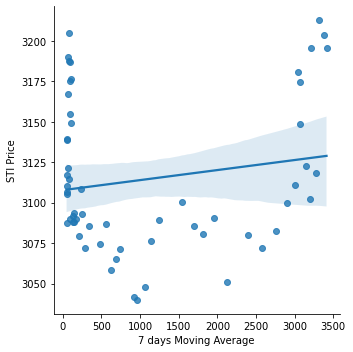

In [42]:
myplot = sns.lmplot(x='7 days Moving Average', y='STI Price', data=df) 

Polynomial Regression might be better

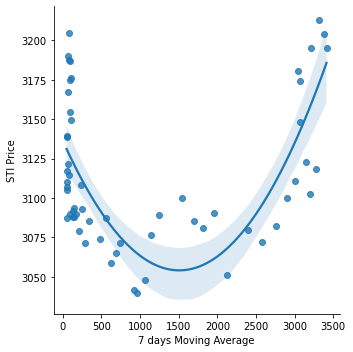

In [43]:
myplot = sns.lmplot(x='7 days Moving Average', y='STI Price', data=df,order = 2) 

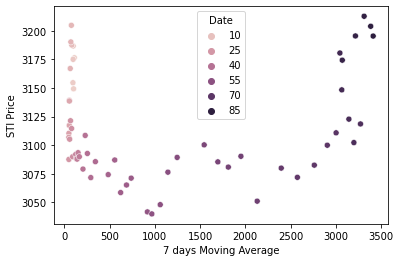

In [44]:
myplot = sns.scatterplot(hue = 'Date',x='7 days Moving Average', y='STI Price', data=df)

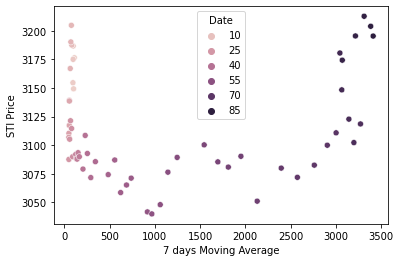

In [45]:
myplot = sns.scatterplot(hue = 'Date',x='7 days Moving Average', y='STI Price', data=df)

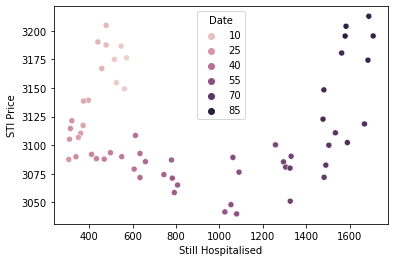

In [46]:
myplot = sns.scatterplot(x='Still Hospitalised', y='STI Price', hue = 'Date', data=df)


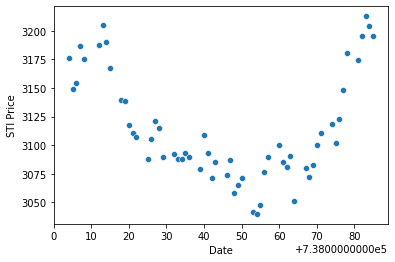

In [47]:
myplot2 = sns.scatterplot(x='Date', y='STI Price', data=df)

# Modelling

In [48]:
def normalize_z(dfin):
   
    dfout = (dfin - dfin.mean(axis=0))/dfin.std(axis=0)

    return dfout

def normalize_minmax(dfin):

    dfout = (dfin - dfin.min(axis=0))/(dfin.max(axis=0)-dfin.min(axis=0))
            
    return dfout


def get_features_targets(df, feature_names, target_names):
    df_feature = df.loc[:,feature_names]
    df_target = df.loc[:,target_names]
    
    return df_feature, df_target

def prepare_feature(df_feature):
    n = df_feature.shape[0]
    ones = np.ones(n).reshape(n,1)

    return np.concatenate((ones,df_feature.to_numpy()),axis = 1)

def prepare_target(df_feature):
    return df_feature.to_numpy()

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    X = prepare_feature(df_feature)

    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)


def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    TestSize = int(test_size*len(df_feature))
    testchoice = np.random.choice(len(df_feature),size = TestSize, replace = False)
    remainder = []
    for i in df_feature.index:
        if i not in testchoice:
            remainder.append(i)
    trainchoice = np.random.choice(remainder, size = len(remainder),replace = False)
        
    df_feature_train = df_feature.iloc[trainchoice]
    df_target_train = df_target.iloc[trainchoice]
    df_feature_test = df_feature.iloc[testchoice]
    df_target_test = df_target.iloc[testchoice]
    
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    rss = np.sum((ypred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    
    return r2

def mean_squared_error(target, pred):
    n = target.shape[0]
    error = target-pred
    mse = np.matmul(error.T,error)/n
    
    return mse

def adjusted_r2_score(y, ypred):
    # The reason for this is that the r2 score is not adjusted for the number of observations
    # Since R2 always increases as you add more predictors to a model, adjusted R2 can serve as a metric that tells you how useful a model is, adjusted for the number of predictors in a model.
    # The adjusted R2 score is calculated as 1 - (1-r2)*(n-1)/(n-p-1)
    r2 = r2_score(y,ypred)
    n = y.shape[0]
    k = y.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
    
    return adj_r2

def evaluate_model(y, ypred):
    r2 = r2_score(y, ypred)
    adjusted_r2 = adjusted_r2_score(y, ypred)
    mse = mean_squared_error(y, ypred)

    print(f"mse : {mse}\n")
    print(f"r2 : {r2}")
    print(f"adjusted r2 : {adjusted_r2}")


In [49]:
def compute_cost(X, y, beta):
    m = X.shape[0]
    y_pred = np.matmul(X,beta)
    error = y_pred - y
    
    # Matrix multiplcation does both sum and square
    J = (1/(2*m))*np.matmul(error.T,error)
    
    return J[0][0] # Extract a scalar value from the 1 x 1 matrix



def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = np.zeros(num_iters)
    
    for i in range(num_iters):
        yp = np.matmul(X,beta)
        error = yp - y
        beta = beta - (alpha/m) * np.matmul(X.T,error)
#         beta = beta - (alpha/m)*np.matmul(X.T,np.matmul(X,beta)-y)
        cost = compute_cost(X,y,beta)
#         print(cost)
        J_storage[i] = cost
#         print(J_storage[i])
    
    
    return beta, J_storage

In [50]:
list(df.columns[:-1])

['Date',
 'Still Hospitalised',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'Phase_Phase 2 (Heightened Alert)',
 'Phase_Preparatory Stage',
 'Phase_Stabilisation Phase']

Using all features as benchmark

In [51]:
feature_column = ['Date',
 'Still Hospitalised',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'Phase_Phase 2 (Heightened Alert)',
 'Phase_Preparatory Stage',
 'Phase_Stabilisation Phase']

# get features and targets from data frame
df_feature, df_target = get_features_targets(df,['Date'],["STI Price"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_feature_train_z = normalize_z(df_feature_train)

X = prepare_feature(df_feature_train) # concatenating for the y intercept
target = prepare_target(df_target_train)

iterations = 10
alpha = 0.0001

num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict method to get the predicted values
df_feature_test_z = normalize_z(df_feature_test)
pred = predict(df_feature_test_z,beta)
print(beta)

evaluate_model(df_target_test, pred)

[[6.93951978e+70]
 [5.12167705e+76]]
mse :                        0
STI Price  2.468854e+153

r2 : STI Price   -1.177086e+150
dtype: float64
adjusted r2 : STI Price   -1.255558e+150
dtype: float64


/tmp/ipykernel_2950/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


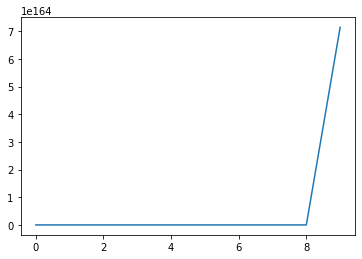

In [52]:
plt.plot(J_storage)

### Normalising Data

In [53]:
feature_column = ['Date',
 'Still Hospitalised',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'Phase_Phase 2 (Heightened Alert)',
 'Phase_Preparatory Stage',
 'Phase_Stabilisation Phase']

# get features and targets from data frame
df_feature, df_target = get_features_targets(df,['Date'],["STI Price"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_feature_train_z = normalize_z(df_feature_train)

X = prepare_feature(df_feature_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)

iterations = 10000
alpha = 0.001

num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict method to get the predicted values
df_feature_test_z = normalize_z(df_feature_test)
pred = predict(df_feature_test_z,beta)
print(beta)

evaluate_model(df_target_test, pred)

[[3112.17201423]
 [  -4.50613225]]
mse :                     0
STI Price  2112.41053

r2 : STI Price   -0.007142
dtype: float64
adjusted r2 : STI Price   -0.074285
dtype: float64


/tmp/ipykernel_2950/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [58]:
len(df_feature_test_z)

17

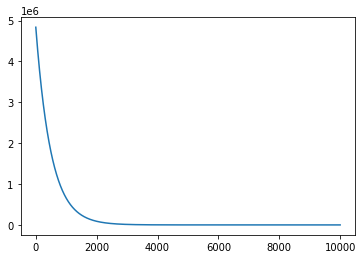

In [56]:
plt.plot(J_storage)

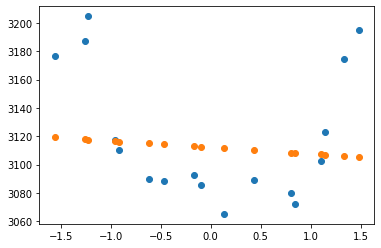

In [20]:
plt.scatter(df_feature_test_z["Date"], df_target_test)
plt.scatter(df_feature_test_z["Date"], pred)

### Using polynomial Features for transformation

In [21]:
def poly_features(df_feature, colname, colname_transformed, degree=2):
    col = df_feature[colname]
    df_feature[colname_transformed] = np.power(col, degree)
    return df_feature

In [29]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date","Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated",5)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3114.77165644]
 [ 114.5365003 ]
 [-123.8267204 ]]
mse :                     0
STI Price  748.564373

r2 : STI Price    0.643104
dtype: float64
adjusted r2 : STI Price    0.619311
dtype: float64


/tmp/ipykernel_2950/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [65]:
# convert dataframe to list
df_features_test_list = df_features_test.values.tolist()
df_features_test_list

[[-0.16797556263689653, 0.14091652326043888],
 [0.9056682418813299, 0.7959533187314604],
 [0.16237637721486545, 0.4285464387923033],
 [-0.9938554122663015, -0.8397883780364044],
 [0.9469622343628001, 0.7970117308312237],
 [1.2773141742145622, 0.9772745216071946],
 [1.2360201817330918, 0.9449288812826357],
 [-0.08538757767395605, 0.22898118243888696],
 [-1.3242073521180635, -1.5759785724985487],
 [-0.49832750248865854, -0.19130577270865506],
 [-1.6958532844512957, -2.2714485264004516],
 [0.49272831706662745, 0.6973901163914364],
 [1.6489601065477943, 1.1935311839518792],
 [-1.0351494047477718, -0.9083205606925213],
 [-1.3655013445995337, -1.678276795401853],
 [1.4837841366219133, 1.1105832720005908],
 [-0.6635034724145396, -0.3850600081911466]]

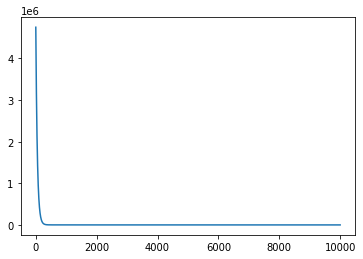

In [28]:
plt.plot(J_storage)

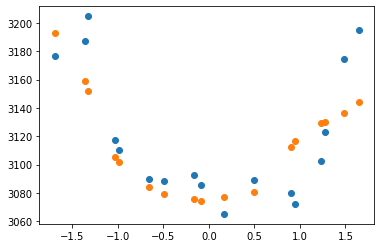

In [24]:
plt.scatter(df_features_test["Date"], df_target_test)
plt.scatter(df_features_test["Date"], pred)

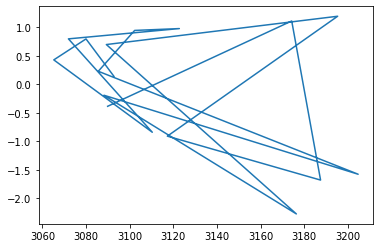

In [25]:
plt.plot(df_target_test,df_features_test["Percentage Vaccinated"])

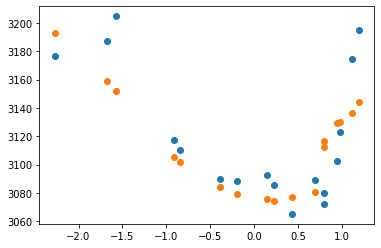

In [26]:
plt.scatter(df_features_test["Percentage Vaccinated"], df_target_test)
plt.scatter(df_features_test["Percentage Vaccinated"], pred)

### Further Experiments

Transforming both P Percentage Vaccinated and Date

In [27]:
df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated")

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 15000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test,beta)

# change target test set to a numpy array
target = df_target.to_numpy()

evaluate_model(df_target_test, pred)

NameError: name 'transform_features' is not defined

Using more variables

In [ ]:
# Normalize dataset
df_norm = normalize_z(df)

# normalize features
# df_features = normalize_minmax(df_features)

# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised","7 days Moving Average","Percentage Vaccinated"],["STI Price"])



# split data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3118.57986772]
 [ -83.82207865]
 [  53.75342824]]
mse :                      0
STI Price  3840.568862

r2 : STI Price   -0.831083
dtype: float64
adjusted r2 : STI Price   -0.953156
dtype: float64


/tmp/ipykernel_6337/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


Using Min Max Norm

In [ ]:
# Normalize dataset
# df_norm = normalize_z(df)

# normalize features
df_features = normalize_minmax(df_features)

# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised","7 days Moving Average","Percentage Vaccinated"],["STI Price"])



# split data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3118.57986772]
 [ -83.82207865]
 [  53.75342824]]
mse :                      0
STI Price  3840.568862

r2 : STI Price   -0.831083
dtype: float64
adjusted r2 : STI Price   -0.953156
dtype: float64


/tmp/ipykernel_6337/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n
